<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Modules" data-toc-modified-id="Load-Modules-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Modules</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Regression-Models" data-toc-modified-id="Regression-Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Regression Models</a></span></li><li><span><a href="#DNN" data-toc-modified-id="DNN-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>DNN</a></span></li></ul></div>

## Load Modules

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from collections import Counter
import collections
import scipy.stats as st
from math import log

from functools import reduce
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA 
import seaborn as sns

import imblearn
from imblearn.over_sampling import SMOTE 

print(imblearn.__version__)

0.8.0


## Feature Engineering

In [2]:
class InformationGainForContinuousVariable: 
    def __init__(self, _inputCSV, _n_bins, _SMOTE_applied=False): 
        
        self.df_org = pd.read_csv(_inputCSV)
        
        cols = self.df_org.columns[1:]
        self.df_transformed = self.df_org.copy()
        self.df_binned = self.df_org.copy()
        
        # standardization 
        x = self.df_transformed[cols]
        scaler_x = preprocessing.StandardScaler().fit(x)
        transformed_x = scaler_x.transform(x)
        for i,c in enumerate(self.df_transformed.columns[1:]):
            self.df_transformed[c] = transformed_x[:,i]

        # binning data   
        cols = self.df_binned.columns[1:-1]
        for c in cols: 
            self.df_binned[c] = self.convert2BinnedData(c, _n_bins)
        
        self.df_binned['binaryTarget'] = self.convert2BinnedData(self.df_transformed.columns[-1], _n_bins)
        
        self.SMOTE_applied = _SMOTE_applied
        if self.SMOTE_applied is True:
            self.ApplySMOTE()
        
        
    def convert2BinnedData(self, col, n_bins):
        coldata = self.df_transformed[col]
        bins = np.linspace(coldata.min()-0.1, coldata.max()+0.1, n_bins)

        binned = []
        for v in coldata: 
            for i in range(len(bins)-1):
                if v >= bins[i] and v < bins[i+1]: 
                    binned.append(i)    

        return binned
    
    
    def ApplySMOTE(self): 
        self.df_temp = self.df_org.copy()
        self.df_temp['binaryTarget'] = self.df_binned.binaryTarget
        cols = self.df_temp.columns[1:-1]
        self.X_org = self.df_temp[cols]
        self.y_org = self.df_temp.binaryTarget

        sm = SMOTE(random_state=42)
        self.X_augmented, self.y_augmented = sm.fit_resample(self.X_org, self.y_org)
        
        
    def EntropyBeforeClassification(self): 
        s = Counter(self.df_binned.binaryTarget)
        
        print(s, "there are %d classes"%len(s))
        
        self.ind_before = list(s.values())
        self.base = len(s)

        self.H_before = st.entropy(self.ind_before,base=self.base)

        print("Entropy before classification: ", self.H_before)
        
        print(" -- For double check -- ")
        Tot = sum(self.ind_before)
        prob = [v/Tot for v in self.ind_before]
        print("Entropy before classification: ",sum(map(lambda x: -x*log(x)/log(self.base), prob)))


    def InstantiatedWeightedEntropy(self, feature, verbosity=False):    
    
        self.df2 = self.df_binned[['binaryTarget',feature]].groupby(feature).agg({'binaryTarget': lambda x: list(x)})
        self.df2['Count'] = [len(i) for i in self.df2['binaryTarget']]
        self.df2.reset_index([feature], inplace=True)

        TotalCount = sum(self.df2.Count)

        weightedEntropy = 0 
        for i in range(self.df2.shape[0]):
            sd  = self.df2.iloc[i].binaryTarget
            cnt = self.df2.iloc[i].Count
            weightedEntropy += st.entropy(list(Counter(sd).values()), base=self.base)*cnt/TotalCount

        if verbosity is True:
            display(self.df2)
            print("weighted Entropy classified by %s is %f"%(feature,weightedEntropy))
        
        return weightedEntropy

    def Cal_InformationGain(self):
        self.EntropyBeforeClassification()
        
        self.IG={}
        for feature in self.df_binned.columns[1:-2]:
            self.IG[feature] = self.H_before - self.InstantiatedWeightedEntropy(feature)
        
        MaxValue = max(self.IG.values())
        
        a = {}
        for k, v in self.IG.items():
            a[k] = v/MaxValue        
            
        self.IG = a
        self.plottingIG()
        
    def plottingIG(self):
        SortedIG = collections.OrderedDict(sorted(self.IG.items(),
                                          key=lambda kv: kv[1], reverse=True))
        keys = SortedIG.keys()
        values = SortedIG.values()
        plt.rcParams.update({'font.size': 15})
        plt.figure(figsize=(15,7))
        plt.bar(keys, values, color='green')
        plt.xticks(rotation=80)
        plt.ylabel('Relative Information Gain',fontsize=15)
    
    def CorrelationMatrix(self):
        corr = self.df_org.corr()
        plt.subplots(figsize=(30,30))
        sns.heatmap(corr,
                    xticklabels=corr.columns, 
                    yticklabels=corr.columns, 
                    annot=True, 
                    cmap=sns.diverging_palette(220, 20, as_cmap=True))
        
        
        
    def PCAFor2majorAxes(self):
        cols = self.df_org.columns[1:-2]

        x = self.df_org[cols]

        pca = PCA(n_components=2)
        
        principalComponents = pca.fit_transform(x)

        principalDf = pd.DataFrame(data=principalComponents, columns = ['PC1', 'PC2'])

        plt.scatter(principalDf['PC1'],principalDf['PC2'])      
        
    def ComparativeHistograms(self,feature):
        plt.figure(figsize=(15,3))
        plt.subplot(1,2,1)
        plt.hist(self.df_org[feature])
        plt.title('original data')
        plt.xlabel(feature)
        plt.ylabel('Occurrence')
        plt.subplot(1,2,2)
        plt.title('normalized data')
        plt.hist(self.df_transformed[feature])
        boundary = max(abs(self.df_transformed[feature])) + 0.1
        plt.xlim([-boundary, boundary])
        plt.xlabel('normalized '+feature)
            

In [3]:
inputCSV = "40192_2013_16_MOESM1_ESM.csv"
n_bins = 6

InstanceName = InformationGainForContinuousVariable(inputCSV, _n_bins=n_bins, _SMOTE_applied=True)


In [4]:
InstanceName.df_org

,Sl. No.,NT,THT,THt,THQCr,CT,Ct,DT,Dt,QmT,...,S,Ni,Cr,Cu,Mo,RedRatio,dA,dB,dC,Fatigue
0,1,885,30,0,0,30,0.0,30.000,0.0,30,...,0.022,0.01,0.02,0.01,0.00,825,0.070,0.020,0.040,232
1,2,885,30,0,0,30,0.0,30.000,0.0,30,...,0.017,0.08,0.12,0.08,0.00,610,0.110,0.000,0.040,235
2,3,885,30,0,0,30,0.0,30.000,0.0,30,...,0.015,0.02,0.03,0.01,0.00,1270,0.070,0.020,0.000,235
3,4,885,30,0,0,30,0.0,30.000,0.0,30,...,0.024,0.01,0.02,0.01,0.00,1740,0.060,0.000,0.000,241
4,5,885,30,0,0,30,0.0,30.000,0.0,30,...,0.022,0.01,0.02,0.02,0.00,825,0.040,0.020,0.000,225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,433,930,30,0,0,930,340.2,895.812,70.2,140,...,0.024,0.02,0.91,0.01,0.15,240,0.050,0.010,0.000,1030
433,434,930,30,0,0,930,340.2,895.812,70.2,140,...,0.015,0.07,1.08,0.08,0.15,530,0.017,0.004,0.008,957
434,435,930,30,0,0,930,340.2,895.812,70.2,60,...,0.019,0.06,1.17,0.07,0.17,690,0.080,0.000,0.000,1104
435,436,930,30,0,0,930,340.2,895.812,70.2,60,...,0.024,0.02,0.91,0.01,0.15,240,0.050,0.010,0.000,1008


Counter({1: 295, 0: 63, 2: 27, 3: 27, 4: 25}) there are 5 classes
Entropy before classification:  0.6537644976947777
 -- For double check -- 
Entropy before classification:  0.6537644976947777


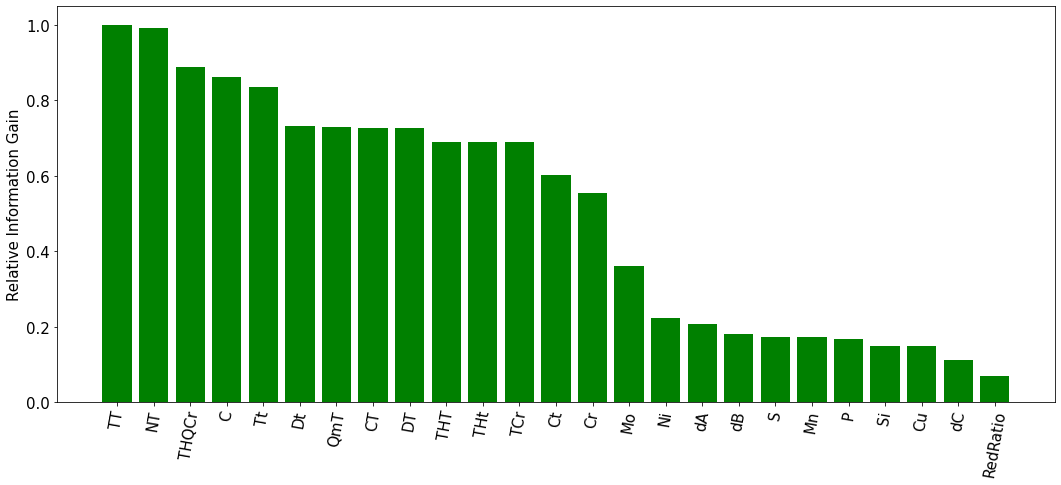

In [49]:
InstanceName.Cal_InformationGain()
plt.tight_layout()
plt.savefig('IG.png')  


In [6]:
y_org = InstanceName.y_org.to_list()
y_aug = InstanceName.y_augmented.to_list()

for i,y in enumerate(y_org): 
    if y in y_aug:
        del y_aug[y_aug.index(y)]

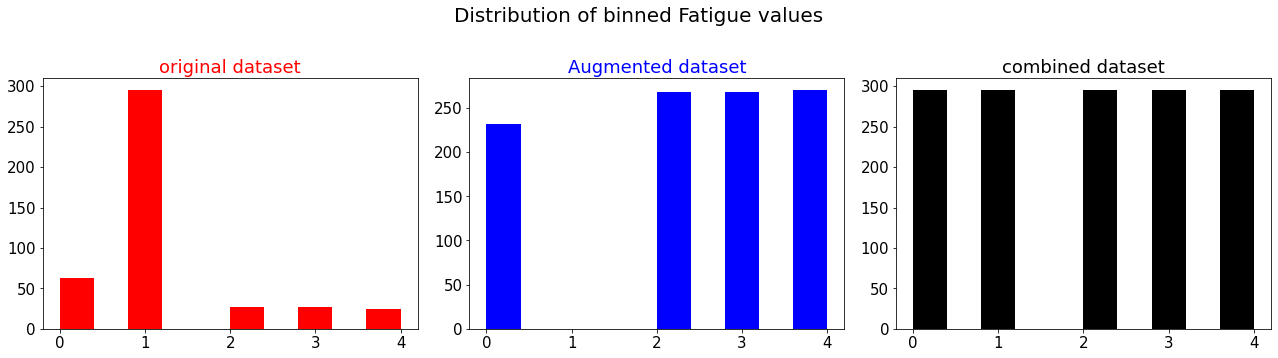

In [48]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
_= plt.hist(y_org, color='r')
_ =plt.title("original dataset", color='r')

plt.subplot(1,3,2)
_= plt.hist(y_aug, color='b')
_=plt.title("Augmented dataset", color='b')

plt.subplot(1,3,3)
_= plt.hist(y_aug+y_org, color='k')
_=plt.title("combined dataset", color='k')

_=plt.suptitle("Distribution of binned Fatigue values", y=1.0, fontsize=20)

plt.tight_layout()
plt.savefig('SMOTE_applied.png')  


## Regression Models

In [8]:
y = InstanceName.X_augmented.pop('Fatigue')
X = InstanceName.X_augmented

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn import linear_model

def evaluations(y_test, y_pred):
    corr, _ = pearsonr(y_test, y_pred)

    EvalMetrics = np.array((corr, 
                            r2_score(y_test, y_pred), 
                            mean_absolute_error(y_test, y_pred),
                            np.sqrt(mean_squared_error(y_test, y_pred))))

    metric_name = ['R', 'R2', 'MAE', 'RMSE']

    df_EvalMetrics = pd.DataFrame(data=EvalMetrics).T

    df_EvalMetrics.columns = metric_name

    return df_EvalMetrics

def ScatterPlot(ytest,ypred):
    plt.scatter(ytest, ypred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    lims = [0, 1400]
    plt.xlim(lims)
    plt.ylim(lims)
    plt.gca().set_aspect('equal', adjustable='box')
    _ = plt.plot(lims, lims, c='k')

In [30]:
class ApplyLinearRegression:
    def __init__(self, _X, _y): 
        if type(X).__module__ is not np.__name__:
            _X = _X.to_numpy()
            _y = _y.to_numpy()
            
        self.X = _X 
        self.y = _y 
        
    def trainbySplit(self):         
        X_train, X_test, y_train, y_test = train_test_split(self.X,self.y, 
                                                            test_size=0.25, 
                                                            random_state=0)
        X_train.shape
        
        #print(X_train.shape, y_train.shape)
        reg = LinearRegression()
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        
        return (y_test, y_pred)

#         display(evaluations(y_pred, y_test))
#         ScatterPlot(y_test, y_pred)

    def LeaveOneOut(self): 
        y_pred = []
        y_test = []
        cv =  LeaveOneOut()
        for train, test in cv.split(self.X):
            model = LinearRegression()
        #    print(test)
            model.fit(self.X[train], self.y[train])
            y_temp = model.predict(self.X[test])[0]
            y_pred.append(y_temp)
            y_test.append(self.y[test][0])

    
        return (y_pred, y_test) 
    
    
    def kfold(self, _n_splits):
        y_pred = []
        y_test = []
        kf =  KFold(n_splits=_n_splits)
        for train, test in kf.split(self.X):
            model = LinearRegression()
            model.fit(self.X[train], self.y[train])
            y_temp = model.predict(self.X[test])[0]
            y_pred.append(y_temp)
            y_test.append(self.y[test][0])

        return (y_pred, y_test) 

In [31]:
LR = ApplyLinearRegression(X,y)

,R,R2,MAE,RMSE
0,0.990803,0.981617,29.061339,36.977008


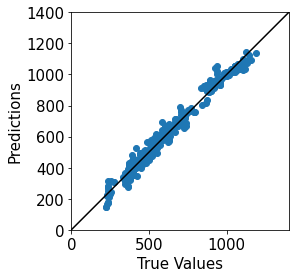

In [32]:
res = LR.trainbySplit()
display(evaluations(res[0], res[1]))
ScatterPlot(res[0], res[1])

,R,R2,MAE,RMSE
0,0.990525,0.980791,28.37331,36.578799


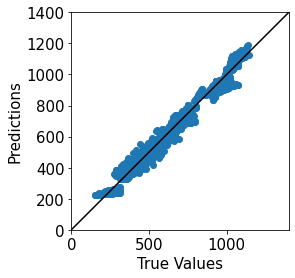

In [33]:
res_LOO = LR.LeaveOneOut()
display(evaluations(res_LOO[0], res_LOO[1]))
ScatterPlot(res_LOO[0], res_LOO[1])

,R,R2,MAE,RMSE
0,0.993073,0.985975,22.079451,31.4578


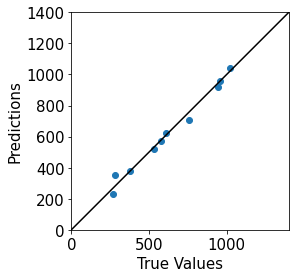

In [34]:
res_KFOLD = LR.kfold(_n_splits=10)
display(evaluations(res_KFOLD[0], res_KFOLD[1]))
ScatterPlot(res_KFOLD[0], res_KFOLD[1])

## DNN

In [15]:
X.shape, y.shape

((1475, 25), (1475,))

In [16]:
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

Init Plugin
Init Graph Optimizer
Init Kernel


In [17]:

def plot_results(model, _X, _y, history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    y_pred = model.predict(_X)
    y_pred_lin = [v[0] for v in y_pred]

    plt.subplot(1,2,2)
    plt.scatter(_y, y_pred_lin)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    Max = max(_y.tolist() + y_pred_lin)
    Min = min(_y.tolist() + y_pred_lin)
    lims = [0, 1600]
    plt.xlim(lims)
    plt.ylim(lims)
    plt.gca().set_aspect('equal', adjustable='box')
    _ = plt.plot(lims, lims, 'k')
    
    return y_pred_lin
    


def evaluations(y_test, y_pred):
    corr, _ = pearsonr(y_test, y_pred)

    EvalMetrics = np.array((corr, 
                            r2_score(y_test, y_pred), 
                            mean_absolute_error(y_test, y_pred),
                            np.sqrt(mean_squared_error(y_test, y_pred))))

    metric_name = ['R', 'R2', 'MAE', 'RMSE']

    df_EvalMetrics = pd.DataFrame(data=EvalMetrics).T

    df_EvalMetrics.columns = metric_name

    return df_EvalMetrics



/Users/gimoonnam/miniforge3/envs/tf25/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-09-10 07:57:44.465393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 16)                416       
_________________________________________________________________
dense_38 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 9         
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________


2021-09-10 07:57:44.746540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-09-10 07:58:32.437981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


,R,R2,MAE,RMSE
0,0.976987,0.932299,43.571099,62.075187


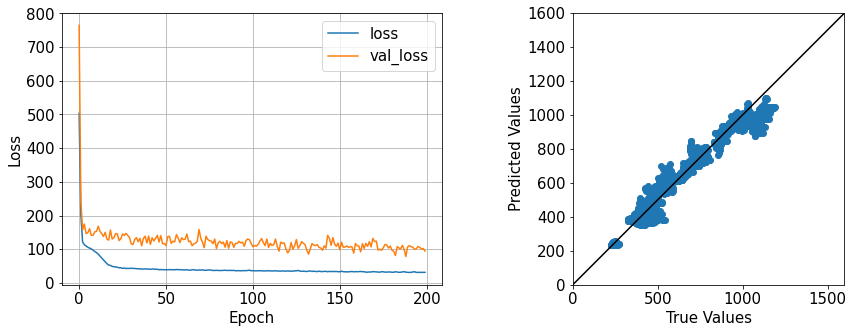

In [42]:
def get_model(_X): 
    model = tf.keras.Sequential([
        Dense(16, input_dim = (_X.shape[1]), activation='relu'),
        Dense(8, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(lr=1e-3),
                  loss=tf.keras.losses.mean_absolute_error)

    return model 

model = get_model(X)

model.summary()

history = model.fit(X, y, validation_split=0.2, epochs=200, batch_size=16, verbose=0)

y_pred_ann = plot_results(model, X, y, history)

evaluations(y_pred_ann, y)